### This is the code for the funcx jetson experiments.
two parts here.  the first is the part that talks to the little web service that talks to the camera.  The second part is the code for the KMeans calculator.  

In [1]:
import time
import numpy as np
import os

In [2]:
from funcx.sdk.client import FuncXClient

In [3]:
fxc = FuncXClient()

We installed funcx-endpoint on the little jetson using the instructions in funcx.org.  
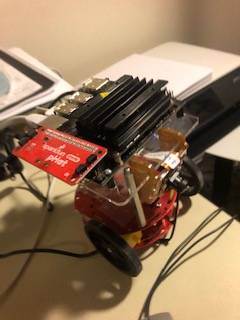
The endpoint is shown below

In [4]:
endpoint ="a7c14a88-d68e-41ae-xxxx-7b419e29e6dd"

In [ ]:
This is the microservices that is run on the jetson device.  
don't execute this block

from bottle import Bottle, run
import numpy as np
import os
app = Bottle()
print("doing import")
from jetcam.csi_camera import CSICamera
print("opening cam")

cam = CSICamera(width=224, height=224, capture_width=1080, capture_height=720, capture_fps=30)

print("got cam")

@app.route('/hello')
def hello():
    print("reading cam")
    image = cam.read()
    print('got image')

    #arr = np.zeros((224,224,3),dtype='uint8')
    
    print(image.shape)
    print(image.dtype)
    filep =  open('image-file', "wb")
    np.save(filep, image)
    filep.close
    return os.getcwd()+'/image-file' 

run(app, host='localhost', port = 7777)


###  A version that uses AWS Simple Queue Service
Next we need to intialize account information.  We only need the aws information for this project

In [30]:
import boto3
accnts = {"az_name":"xxxxx",
          "az_key":"xxxxxx;EndpointSuffix=core.windows.net",
          'aw_id':"xxxxxx",
          'aw_sec_key':"xxxxxxxxxxxx"}
sqs = boto3.resource('sqs', 'us-west-2', aws_access_key_id=accnts['aw_id'],
                          aws_secret_access_key=accnts['aw_sec_key'])

In [31]:
q1 = sqs.get_queue_by_name(QueueName='funcx-queue1.fifo')
q2 = sqs.get_queue_by_name(QueueName='funcx-queue2.fifo')

### The remote function
understand_image is the function we will launch remotly on the jetson device.   

I has 3 communication functions and then it goes into the initialization of the image recognition model.   It assumes that the imagenet labels file exists on the remote device.



In [142]:
def understand_image(queue_out, queue_in, accnts):
    import torch
    import numpy as np
    import boto3
    import json
    import time
    from botocore.exceptions import ClientError
    from torchvision import models
    from torchvision import transforms

    sqs = boto3.resource('sqs', 'us-west-2',   
        aws_access_key_id=accnts['aw_id'],
        aws_secret_access_key=accnts['aw_sec_key'])

    q_in = sqs.get_queue_by_name(QueueName=queue_in)
    q_out = sqs.get_queue_by_name(QueueName=queue_out)

    def receive_message(queue, max_number, wait_time):
        try:
            messages = queue.receive_messages(
                MessageAttributeNames=['All'],
                MaxNumberOfMessages=max_number,
                WaitTimeSeconds=wait_time
            )
        except ClientError as error:
            raise error
        else:
            return messages

    def send_message(queue, message_body):
        try:
            response = queue.send_message(
                MessageBody=message_body,
                MessageAttributes={},
                MessageGroupId='funcx',
                MessageDeduplicationId=str(time.time())
            )
        except ClientError as error:
            logger.exception("Send message failed: %s", message_body)
            raise error
        else:
            return response

    def decode_msg(m):
        bod = m[0].body
        m[0].delete()
        action = ''
        action = json.loads(bod)['action']
        return action  

    preprocess =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize(
            mean = [0.485, 0.456, 0.406],
            std = [0.229, 0.244, 0.225])
    ])
 
    msg = {"info":"loading model"} 
    send_message(q_out, str(msg))
    resnet_gpu = models.resnet18(pretrained = True)
    resnet_gpu.eval()
  
    msg = {"info":"model loaded"} 
    send_message(q_out, str(msg))

    if torch.cuda.is_available():
        resnet_gpu.to('cuda')
        msg = {"info":"model cuda-ized"} 
        send_message(q_out, str(msg))
    else:
        msg = {"info":"no cuda"} 
        send_message(q_out, str(msg))
 
    with open('/home/jetbot/imagenet_classes.txt') as f:
        labels = [line.strip() for line in f.readlines()]

    def get_label(out, labels=labels):
        _, index = torch.max(out, 1)
        percentage = torch.nn.functional.softmax(out, dim=1)[0]*100
        return (labels[index[0]], percentage[index[0]].item())

    def take_picture():
        req = requests.get('http://localhost:7777/getimage')
        print(req)
        imagefile = 'image-file.jpg'
        print('doing ', imagefile)
        img = Image.open(imagefile)
        img_t = preprocess(img)
        batch_t =  torch.unsqueeze(img_t, 0)
        print(batch_t.shape)

        batch_gpu = batch_t.to('cuda')
        print('cuda-ized')

        t0 =  time.time()

        with torch.no_grad():
            out_gpu = resnet_gpu(batch_gpu)
        label = get_label(out_gpu)

        t1 = time.time()

        msg = {"class":label[0], "time":str(t1-t0)} 
        print(msg["class"])
        send_message(q_out, str(msg))
   

    from PIL import Image
    import requests

    #This is the main loop.  in this version it is a fixed number of iterations (400), 
    #each iteration begins with an attempted receipt of a message.  if there is no messing
    #in the 5 second window it continues and tries again.  This means that if it hasn't received 
    #a request in 2000 seconds it will exit.  
    #There are two possible messages of interest:
    #  1.  "quit" which terminates the function
    #  2.  "take picture" - this causes a web-service call to the little web service
    #      that protects the camera.  it leaves the image in  "image-file.jpg" on the
    #      jetson device.  The analysis is timed and the result sent back to the client.
    for _ in range(400):
        print('checking q_in')
        m = receive_message(q_in, 1, 5)
        action = ''
        if m != []:
             print('got msg=', m[0].body)
             action = decode_msg(m)
             if action == 'quit':
                  msg = {"action":"quiting"} 
                  send_message(q_out, str(msg))
                  print('going down')
                  return "quit sent";
             elif action == 'take picture':
                  req = requests.get('http://localhost:7777/getimage')
                  print(req)
                  imagefile = 'image-file.jpg'
                  print('doing ', imagefile)
                  img = Image.open(imagefile)
                  img_t = preprocess(img)
                  batch_t =  torch.unsqueeze(img_t, 0)
                  print(batch_t.shape)

                  batch_gpu = batch_t.to('cuda')
                  print('cuda-ized')

                  t0 =  time.time()

                  with torch.no_grad():
                      out_gpu = resnet_gpu(batch_gpu)
                  label = get_label(out_gpu)

                  t1 = time.time()

                  msg = {"class":label[0], "time":str(t1-t0)} 
                  print(msg["class"])
                  send_message(q_out, str(msg))
   		     
    return "all done"


In [143]:
func_uuid = fxc.register_function(understand_image)

In [144]:
res = fxc.run('funcx-queue1.fifo', 'funcx-queue2.fifo', accnts, endpoint_id=endpoint, function_id=func_uuid)


In [147]:
fxc.get_task(res)

{'pending': False,
 'status': 'success',
 'result': 'quit sent',
 'completion_t': '1610049019.1454186'}

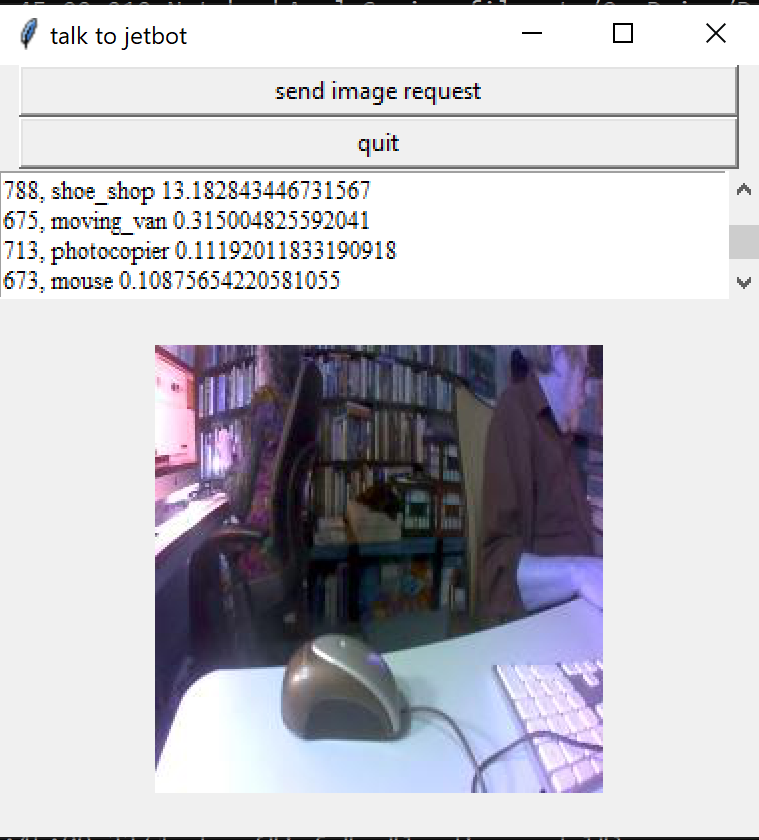

The following functions are for queue maintenance..

In [52]:
import json
def receive_message(queue, max_number, wait_time):
    try:
        messages = queue.receive_messages(
            MessageAttributeNames=['All'],
            MaxNumberOfMessages=max_number,
            WaitTimeSeconds=wait_time
        )
    except ClientError as error:
        raise error
    else:
        return messages
def empty_queue1(k):
    for _ in range(k):
        m =receive_message(q1, 1, 3)
        if m != []:
            bod = m[0].body
            m[0].delete()
            bod = bod.replace("'", '"')
            bod = json.loads(bod)
            if "class" in bod:
                print(bod["class"],bod["time"])
            elif "info" in bod:
                print(bod["info"]) 
                
def empty_queue2(k):
    for _ in range(k):
        m =receive_message(q2, 1, 3)
        if m != []:
            bod = m[0].body
            m[0].delete()
            bod = bod.replace("'", '"')
            bod = json.loads(bod)
            print(bod)
            if "class" in bod:
                print(bod["class"],bod["time"])
            elif "info" in bod:
                print(bod["info"]) 

                
def send_quit():
    send_message(q2, '{"action":"quit"}') 

In [77]:
empty_queue2(1)

{'action': 'quit'}


### This is the pika version
The difference between this version and the aws version is that the queue reads are implicit and managed through the basic_consume callback function.  here that function is just called callback.

To RabbitMQ server is running on a sepereate machine (10.0.0.30) in the local area network.  We have two queues "hello" and "command".   messages from the remote function go to the  hello queue. 

Commands from the client are either "quit" or "take picture" and go to the remote function via the command channel. 

In [135]:
def pika_understand():
    import pika
    import requests
    import json
    import time
    import sys
    import torch
    import numpy as np
    from torchvision import models
    from torchvision import transforms
    from PIL import Image

    creds = pika.PlainCredentials('jetbot','jetbot')
    parms = pika.ConnectionParameters('10.0.0.30', 5672, "/", creds)
    connection = pika.BlockingConnection(parms)
    channel = connection.channel()
    channel.queue_declare(queue='hello')
    channel.queue_declare(queue='command')

    def send_message(channel, body):
         channel.basic_publish(exchange='',
                          routing_key='hello',
                          body=body)

    preprocess =  transforms.Compose([
           transforms.Resize(256),        
           transforms.CenterCrop(244),
           transforms.ToTensor(),
           transforms.Normalize(
               mean = [0.485, 0.456, 0.406],
               std = [0.229, 0.244, 0.225])
    ])

    msg = {"info":"loading model"} 
    send_message(channel, str(msg))
    resnet_gpu = models.resnet18(pretrained = True)
    resnet_gpu.eval()
    msg = {"info":"model loaded"} 
    send_message(channel, str(msg))

    if torch.cuda.is_available():
            resnet_gpu.to('cuda')
            msg = {"info":"model cuda-ized"} 
            send_message(channel, str(msg))
    else:
            msg = {"info":"no cuda"} 
            send_message(channel, str(msg))

    with open('/home/jetbot/imagenet_classes.txt') as f:
            labels = [line.strip() for line in f.readlines()]

    def get_label(out, labels=labels):
            _, index = torch.max(out, 1)
            percentage = torch.nn.functional.softmax(out, dim=1)[0]*100
            return (labels[index[0]], percentage[index[0]].item())


    def take_picture():
            #print('doing request')
            msg = {"info":"taking picture"} 
            send_message(channel, str(msg))
            req = requests.get('http://localhost:7777/getimage')
            print(req)
            imagefile = 'image-file.jpg'
            print('doing ', imagefile)
            img = Image.open(imagefile)
            img_t = preprocess(img)
            batch_t =  torch.unsqueeze(img_t, 0)
            #print(batch_t.shape)

            batch_gpu = batch_t.to('cuda')
            print('cuda-ized')

            t0 =  time.time()

            with torch.no_grad():
                out_gpu = resnet_gpu(batch_gpu)
            label = get_label(out_gpu)

            t1 = time.time()
            #label = ["big dog2"]

            msg = {"class":label[0], "time":str(t1-t0)} 
            #print(msg["class"])
            send_message(channel, str(msg))

    def callback(ch, method, properties, body):
        if body==b'quit':
            channel.stop_consuming()
            return 'leaving callback'
        if body==b'take picture':
            take_picture()

    channel.basic_consume(queue='command', on_message_callback=callback, auto_ack=True)

    channel.start_consuming()
    return('done.')

In [136]:
func_uuid = fxc.register_function(pika_understand)

In [137]:
res = fxc.run(endpoint_id=endpoint, function_id=func_uuid)


In [140]:
fxc.get_task(res)

{'pending': False,
 'status': 'success',
 'result': 'done.',
 'completion_t': '1610046855.1830962'}

The image below is a screengrab of the client app "talk to jetbot".  The image is of our book-lined office.  

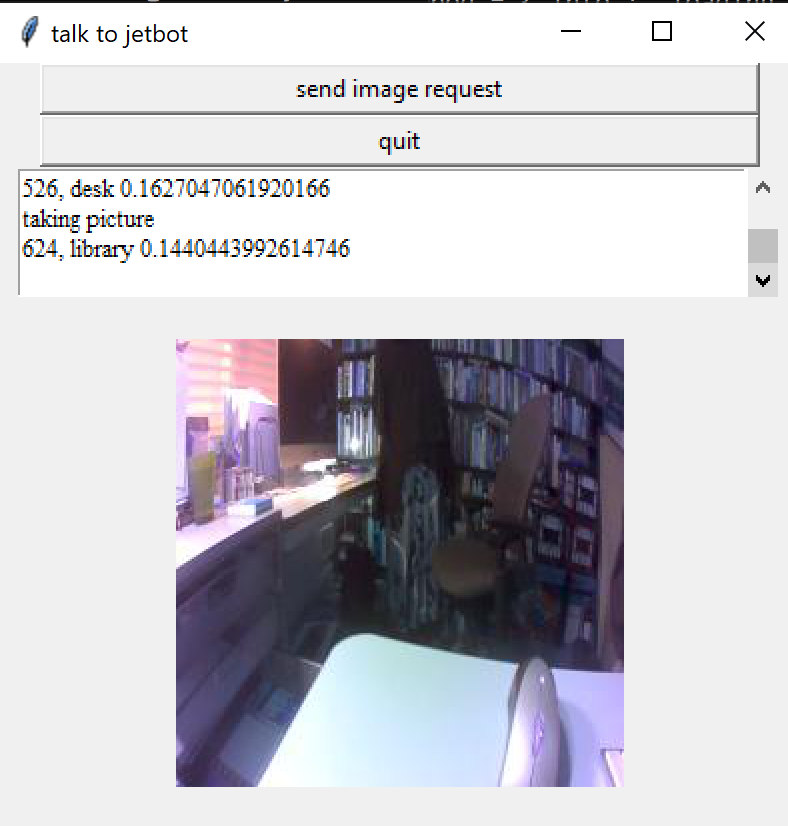

Text below is full text from talk to jetbot

In [ ]:
ready.
loading model
model loaded
model cuda-ized
taking picture
423, barber_chair 21.04596734046936
taking picture
526, desk 0.1627047061920166
taking picture
624, library 0.1440443992614746
